## Renify 
Please ensure that you're using a GPU runtime

First some setup:

##Setup

Only works for Tensorflow 1, using Colab helps make version control a bit easier. May need to restart runtime after changing tensorflow versions 

In [ ]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [ ]:
#Can check your version with this snippet, should be 1.15.2
#import tensorflow as tf
#tf.__version__

In [ ]:
!git clone https://github.com/justinpinkney/stylegan2 #Borrow a lot from Justin Pinkney's styleGAN2 library, go check it out https://github.com/justinpinkney/stylegan2 #He borrows from others, check out his credits for some good code. 
%cd stylegan2
!nvcc test_nvcc.cu -o test_nvcc -run #Checks

fatal: destination path 'stylegan2' already exists and is not an empty directory.
/content/stylegan2
CPU says hello.
GPU says hello.


In [ ]:
!mkdir raw
!mkdir aligned
!mkdir generated

mkdir: cannot create directory ‘raw’: File exists
mkdir: cannot create directory ‘aligned’: File exists
mkdir: cannot create directory ‘generated’: File exists


In [ ]:
#Use this to clear the directories if they get too clogged up from previous runs 
#!rm stylegan2/raw/*
#!rm stylegan2/aligned/*
#!rm stylegan2/generated/*

## Upload photos (Can do this manually in lieu of running this, see below)

Upload your photos to `raw/`. These don't need to be aligned as we'll use a face detector to grab all the faces and transform them into the correct format. One note of caution is that you'll need a pretty high-resolution picture of a face to get a sharp result (the final face crop is resized to 1024x1024 pixels)

We'll grab a example image from the internet to work with.

The basic process is:
- Extract faces and align the images
- Project the images (i.e. find the latent code)
- Toonify the images (i.e. use the latent code with the Renaissance model)

Results will be placed in the stylegan2/generated folder

**TO RUN MANUALLY:**

Just upload your photos into google colab from your local device and move them into the directory stylegan2/raw/ Only human face photos and .jpg or .png files should be in this folder


In [ ]:
#Shinzo Abe
!wget https://upload.wikimedia.org/wikipedia/commons/6/6d/Shinz%C5%8D_Abe_Official.jpg -O raw/example_sa.jpg

--2021-01-14 02:41:01--  https://upload.wikimedia.org/wikipedia/commons/6/6d/Shinz%C5%8D_Abe_Official.jpg
Resolving upload.wikimedia.org (upload.wikimedia.org)... 91.198.174.208, 2620:0:862:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|91.198.174.208|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 332712 (325K) [image/jpeg]
Saving to: ‘raw/example_sa.jpg’

raw/example_sa.jpg  100%[===================>] 324.91K  --.-KB/s    in 0.02s   

2021-01-14 02:41:01 (15.6 MB/s) - ‘raw/example_sa.jpg’ saved [332712/332712]



In [ ]:
#These are actually StyleGAN-generated photos (ie not real people)
#StyleGANsample1
!wget https://github.com/GeorgeDavila/Renify/blob/main/Renify_inputs/styleGANsample1.jpg?raw=true -O raw/example_sg1.jpg

#StyleGANsample1
!wget https://github.com/GeorgeDavila/Renify/blob/main/Renify_inputs/styleGANsample4.jpg?raw=true -O raw/example_sg4.jpg

#StyleGANsample1
!wget https://github.com/GeorgeDavila/Renify/blob/main/Renify_inputs/styleGANsample7.jpg?raw=true -O raw/example_sg7.jpg

#StyleGANsample1
!wget https://github.com/GeorgeDavila/Renify/blob/main/Renify_inputs/styleGANsample11.jpg?raw=true -O raw/example_sg11.jpg

--2021-01-14 02:41:01--  https://github.com/GeorgeDavila/Rennify/blob/main/Rennify_inputs/styleGANsample1.jpg?raw=true
Resolving github.com (github.com)... 140.82.121.4
Connecting to github.com (github.com)|140.82.121.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/GeorgeDavila/Rennify/raw/main/Rennify_inputs/styleGANsample1.jpg [following]
--2021-01-14 02:41:01--  https://github.com/GeorgeDavila/Rennify/raw/main/Rennify_inputs/styleGANsample1.jpg
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/GeorgeDavila/Rennify/main/Rennify_inputs/styleGANsample1.jpg [following]
--2021-01-14 02:41:01--  https://raw.githubusercontent.com/GeorgeDavila/Rennify/main/Rennify_inputs/styleGANsample1.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (ra

In [ ]:
# My ugly mug :'( Also example of importing your own photo from google drive in case you want to do that 
!gdown https://drive.google.com/uc?id=1TQDB97-rKnv6nJLeFc2XcfVLEPB72AC6 -O raw/example_me.jpg 
#!mv ucfphoto.png raw_images

Downloading...
From: https://drive.google.com/uc?id=1TQDB97-rKnv6nJLeFc2XcfVLEPB72AC6
To: /content/stylegan2/raw/example_me.jpg
100% 41.8k/41.8k [00:00<00:00, 76.1MB/s]


##Run Models 

Runs the models

A few things to note:


*   Runs on DLib for face dtection, can get errors if it cant dect a face. This may be because no human face is in the photo or the face is hard to recognize (bad angle, face too small in photo or maybe you're just really ugly sorry) 
*   Can take a relatively long while to run this section (~ 5 to 10 mins)
*   Runs on all photos in your /raw/ directory, the more photos you have the longer it takes to run



In [ ]:
#https://drive.google.com/uc?id=1H-MYFZqngF1R0whm4bc3fEoX7VvOWaDl
import pretrained_networks

# Download models 
# get the original here https://mega.nz/folder/OtllzJwa#C947mCCdEfMCRTWnDcs4qw
blended_url = "https://drive.google.com/uc?id=1H-MYFZqngF1R0whm4bc3fEoX7VvOWaDl" 

ffhq_url = "http://d36zk2xti64re0.cloudfront.net/stylegan2/networks/stylegan2-ffhq-config-f.pkl"  

_, _, Gs_blended = pretrained_networks.load_networks(blended_url)
_, _, Gs = pretrained_networks.load_networks(ffhq_url)

Setting up TensorFlow plugin "fused_bias_act.cu": Preprocessing... Loading... Done.
Setting up TensorFlow plugin "upfirdn_2d.cu": Preprocessing... Loading... Done.


Take the images from the folder raw/ and align them (ie make them portrait-style photos), then place the aligned images in aligned/

In [ ]:
!python align_images.py raw aligned

**The following Cell takes fairly long to run, like 2 to 3 mins per photo**

Can be reduced by: 

*   Decreasing number of photos in your raw/ and aligned/ file (technically runs from aligned/ but you should have the same number of pics in both aligned/ and raw/ folders)
*   Decreasing number of steps (reduces quality, but you might find the tradeoff acceptable)
*   Reducing pixel size or resolution of photo



In [ ]:
#Run align images on the photos, can play around with number of steps (more steps generally more time but better results up to a given point )
!python project_images.py --num-steps 500 aligned generated
#!python project_images.py --num-steps 500 aligned generated

Loading networks from "http://d36zk2xti64re0.cloudfront.net/stylegan2/networks/stylegan2-ffhq-config-f.pkl"...
Setting up TensorFlow plugin "fused_bias_act.cu": Preprocessing... Loading... Done.
Setting up TensorFlow plugin "upfirdn_2d.cu": Preprocessing... Loading... Done.
Loading images from ".stylegan2-tmp/dataset/images"
detected 1 images ...
Creating dataset ".stylegan2-tmp/dataset/tfrecords"
Adding the images to tfrecords ...
added images 0
Added 1 images.
Projecting image "example_me_01.png"...
Loading images from ".stylegan2-tmp/dataset/images"
detected 1 images ...
Creating dataset ".stylegan2-tmp/dataset/tfrecords"
Adding the images to tfrecords ...
added images 0
Added 1 images.
Projecting image "example_sa_01.png"...
Loading images from ".stylegan2-tmp/dataset/images"
detected 1 images ...
Creating dataset ".stylegan2-tmp/dataset/tfrecords"
Adding the images to tfrecords ...
added images 0
Added 1 images.
Projecting image "example_sg11_01.png"...
Loading images from ".style

##Show Results 

In [ ]:
import numpy as np
from PIL import Image
import dnnlib
import dnnlib.tflib as tflib
from pathlib import Path

latent_dir = Path("generated")
latents = latent_dir.glob("*.npy")
for latent_file in latents:
  latent = np.load(latent_file)
  latent = np.expand_dims(latent,axis=0)
  synthesis_kwargs = dict(output_transform=dict(func=tflib.convert_images_to_uint8, nchw_to_nhwc=False), minibatch_size=8)
  images = Gs_blended.components.synthesis.run(latent, randomize_noise=False, **synthesis_kwargs)
  Image.fromarray(images.transpose((0,2,3,1))[0], 'RGB').save(latent_file.parent / (f"{latent_file.stem}-rennify.jpg"))


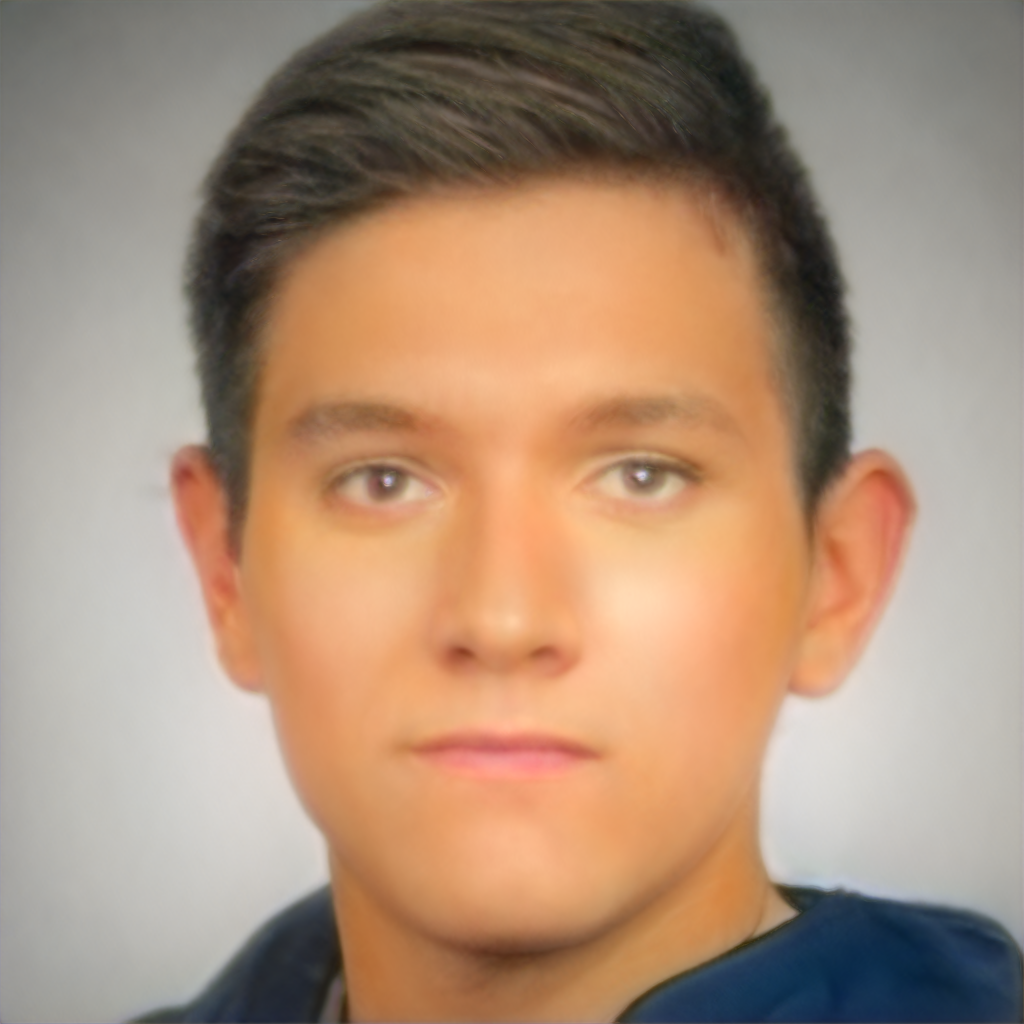

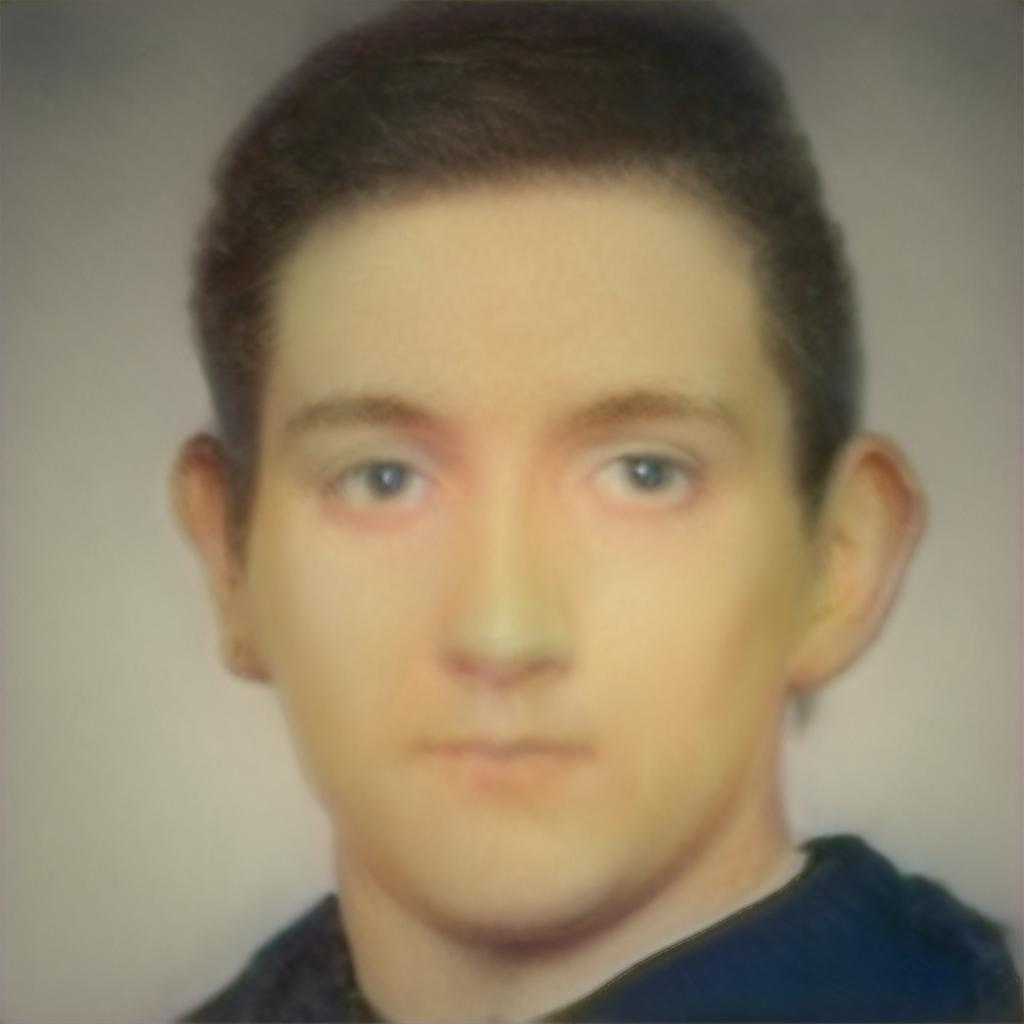

In [ ]:
from IPython.display import Image 
embedded = Image(filename="generated/example_me_01.png", width=256)
display(embedded)
tooned = Image(filename="generated/example_me_01-rennify.jpg", width=256)
display(tooned)

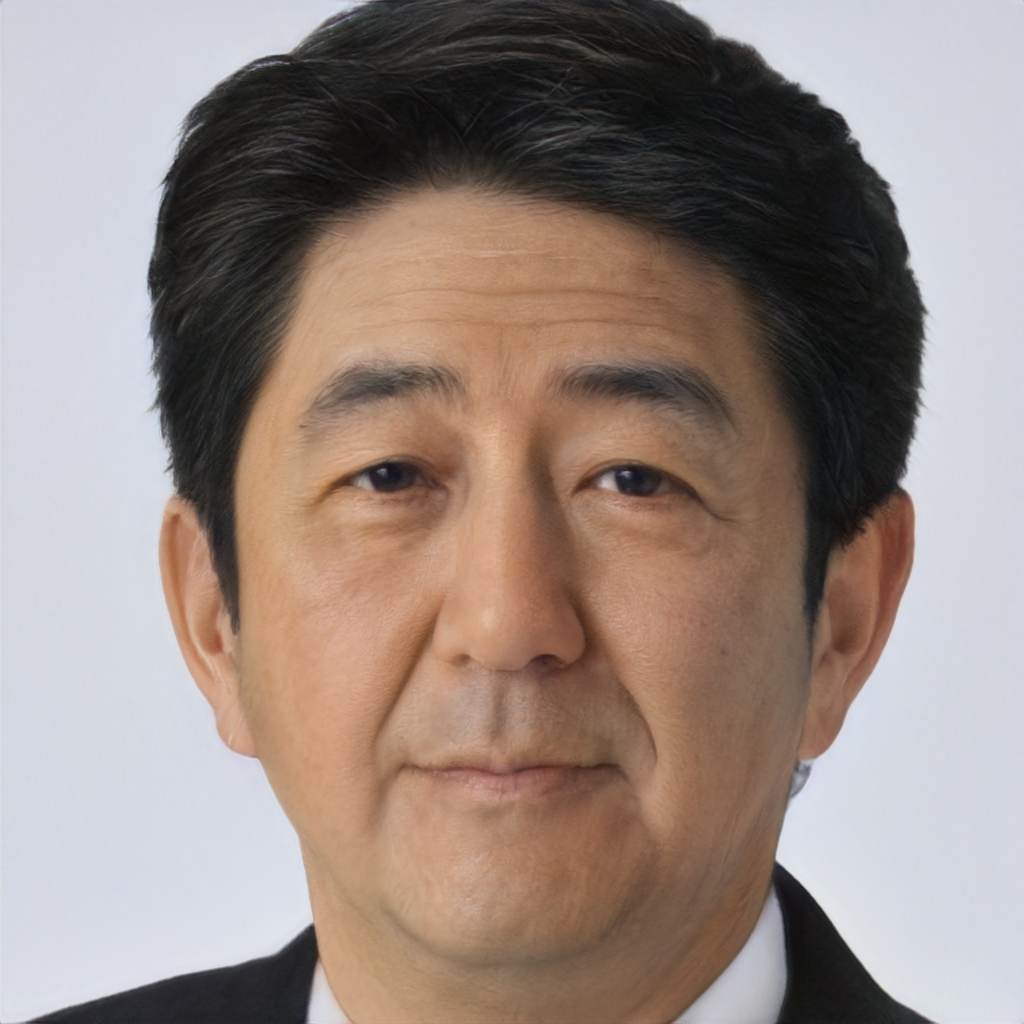

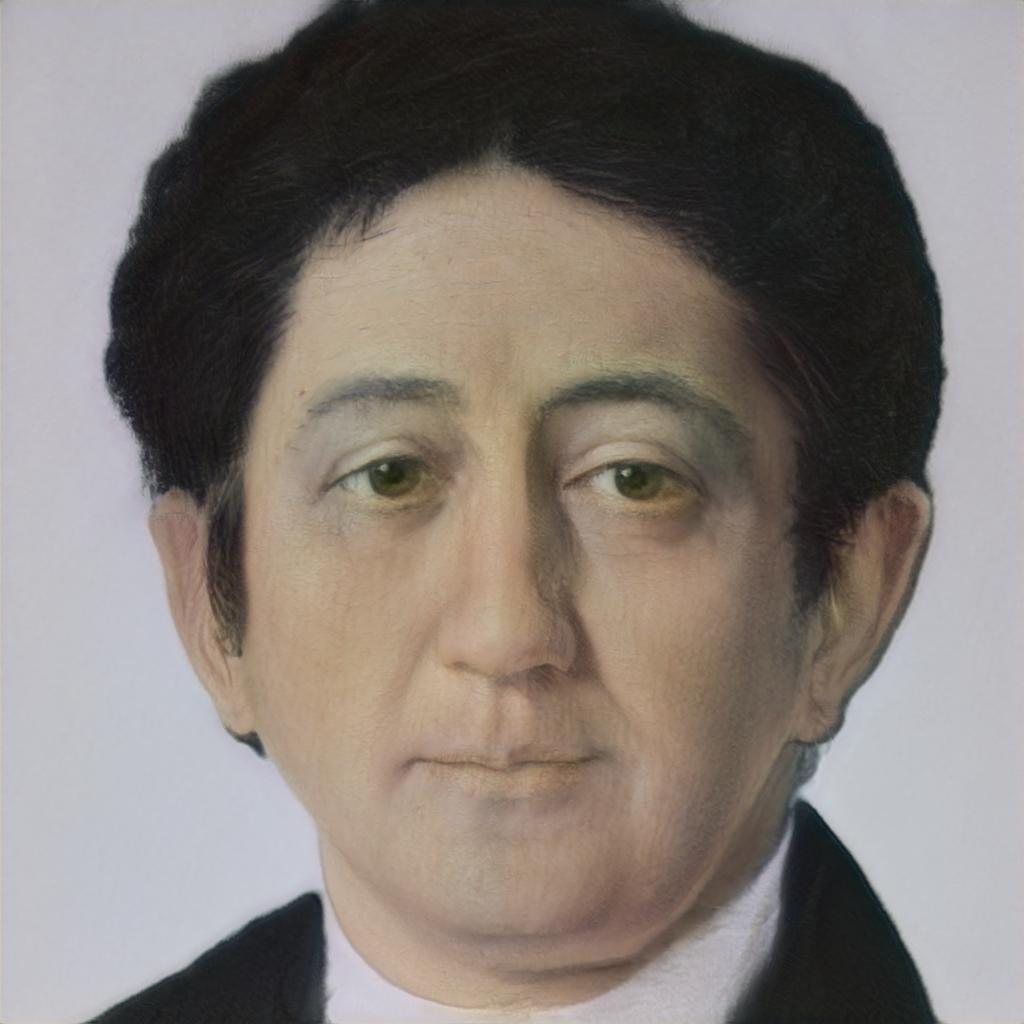

In [ ]:
from IPython.display import Image 
embedded = Image(filename="generated/example_sa_01.png", width=256)
display(embedded)
tooned = Image(filename="generated/example_sa_01-rennify.jpg", width=256)
display(tooned)

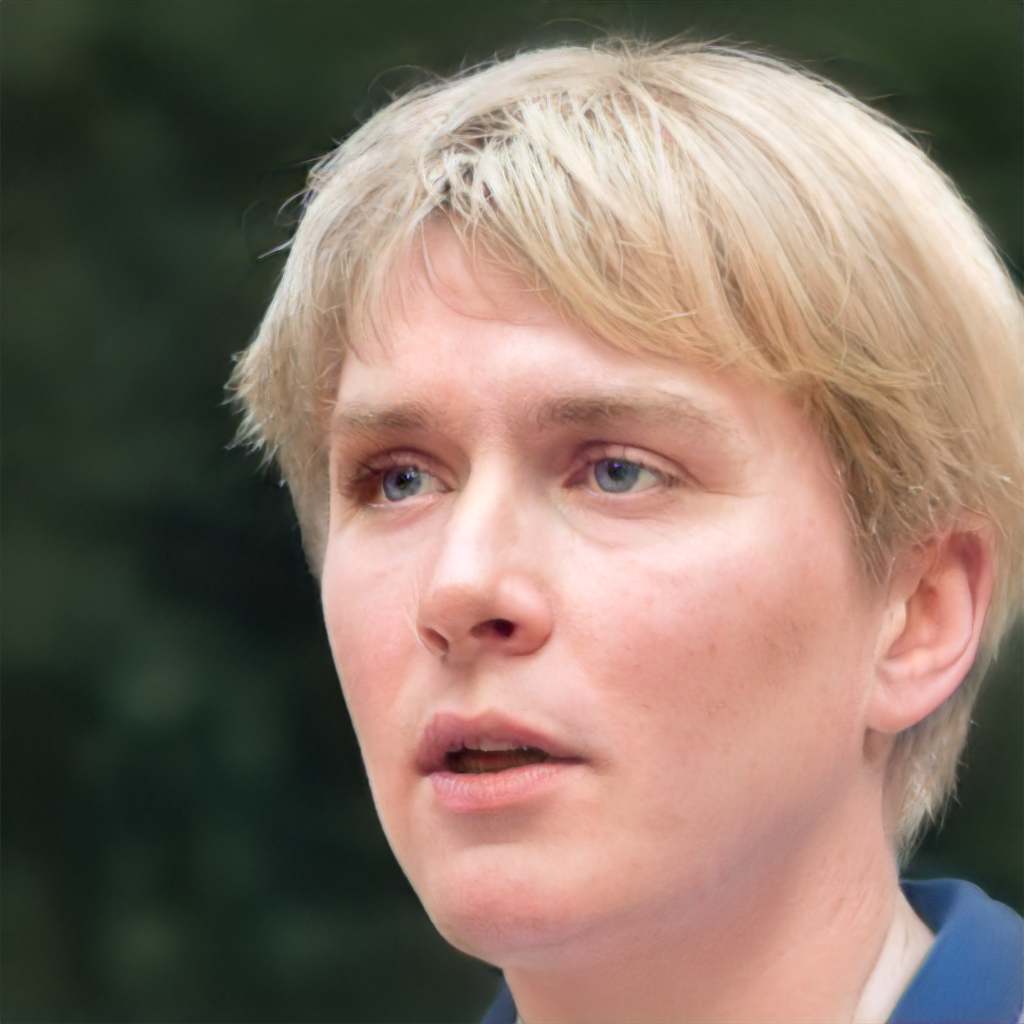

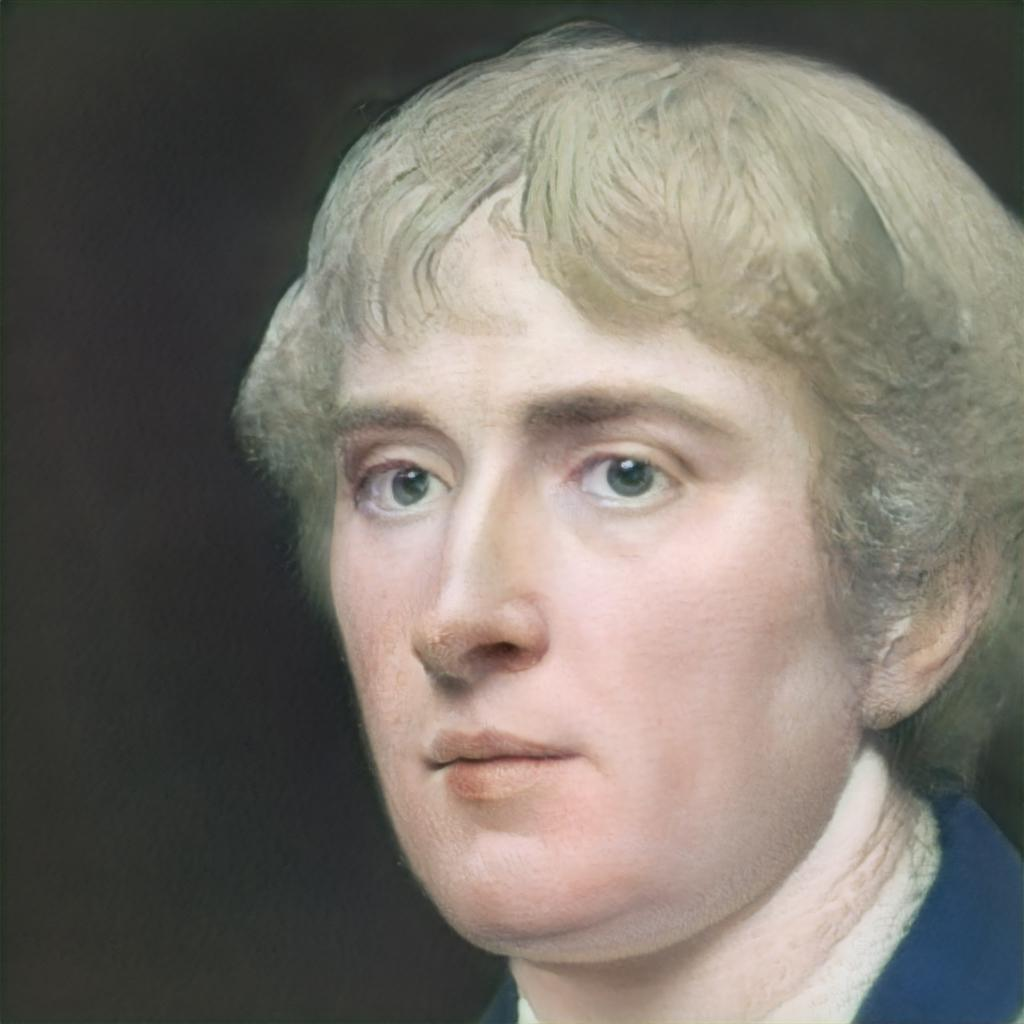

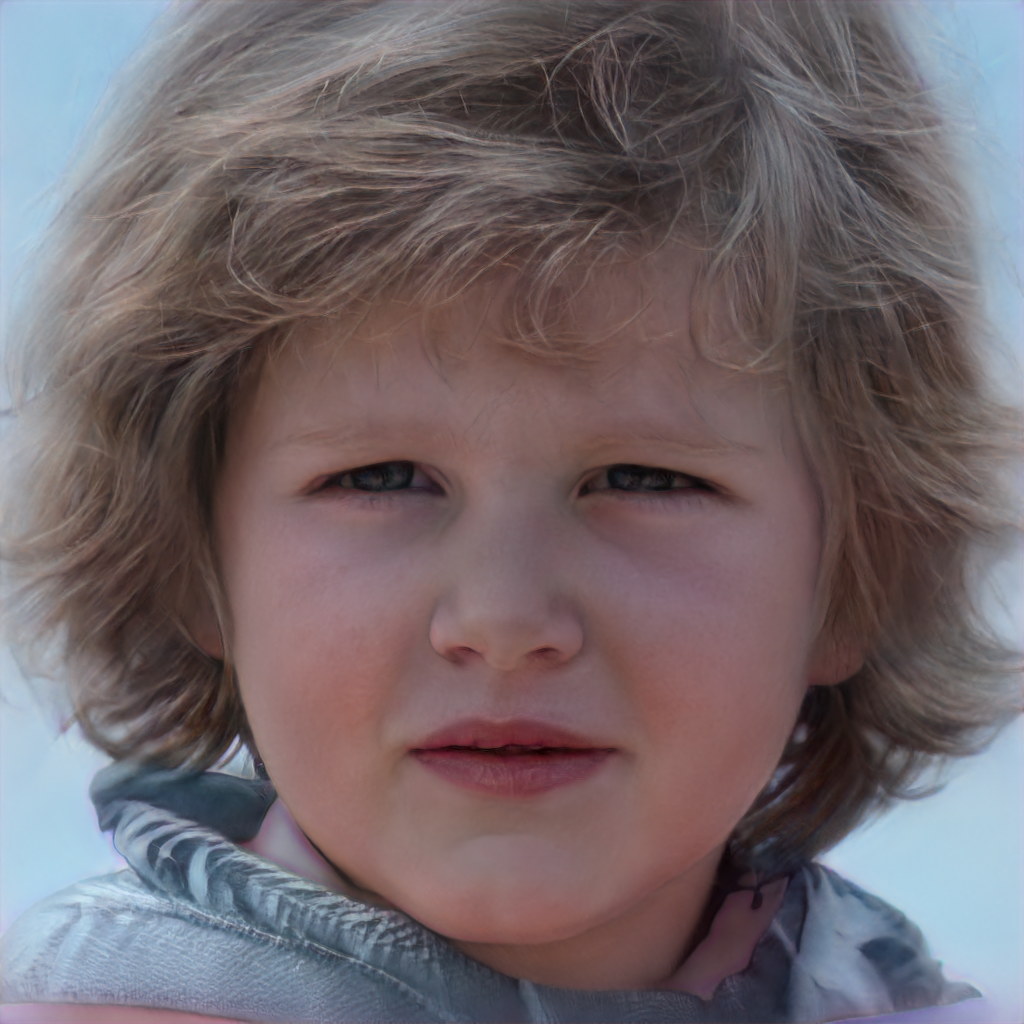

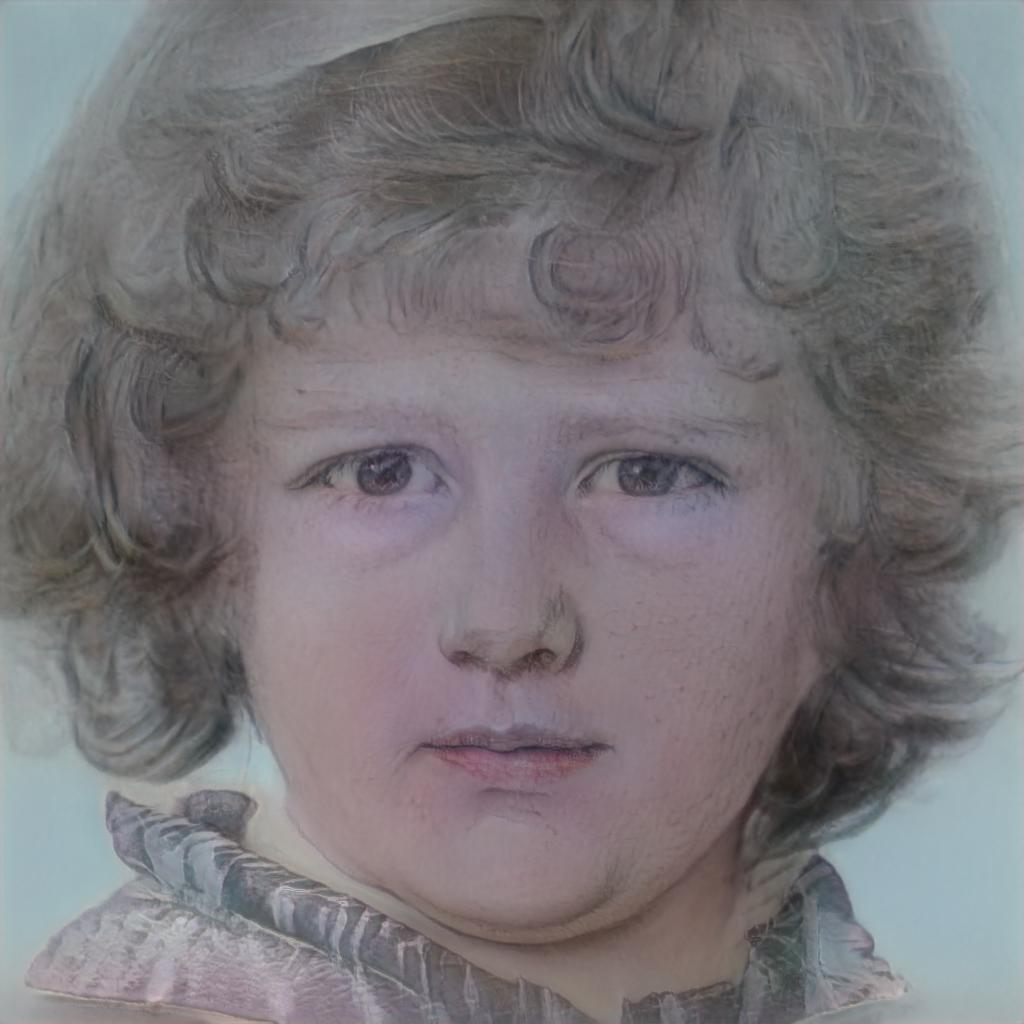

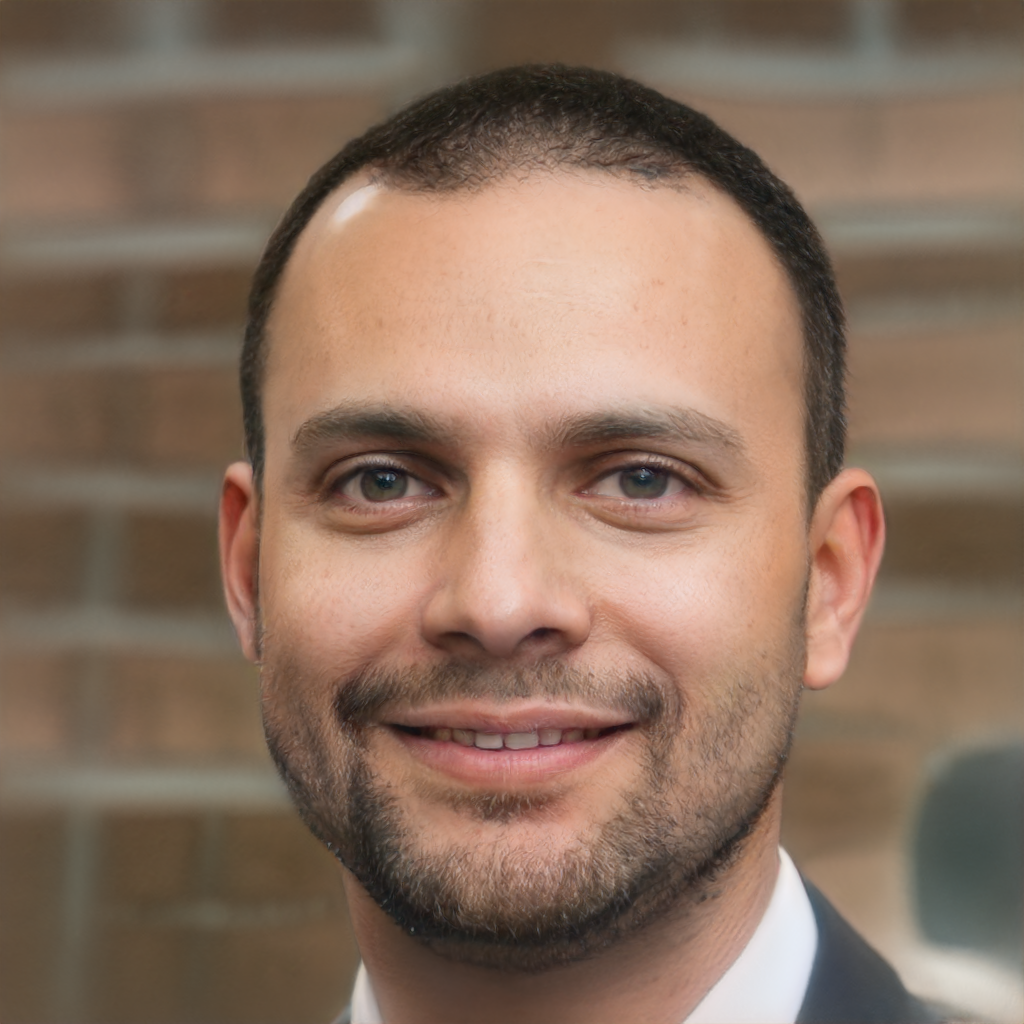

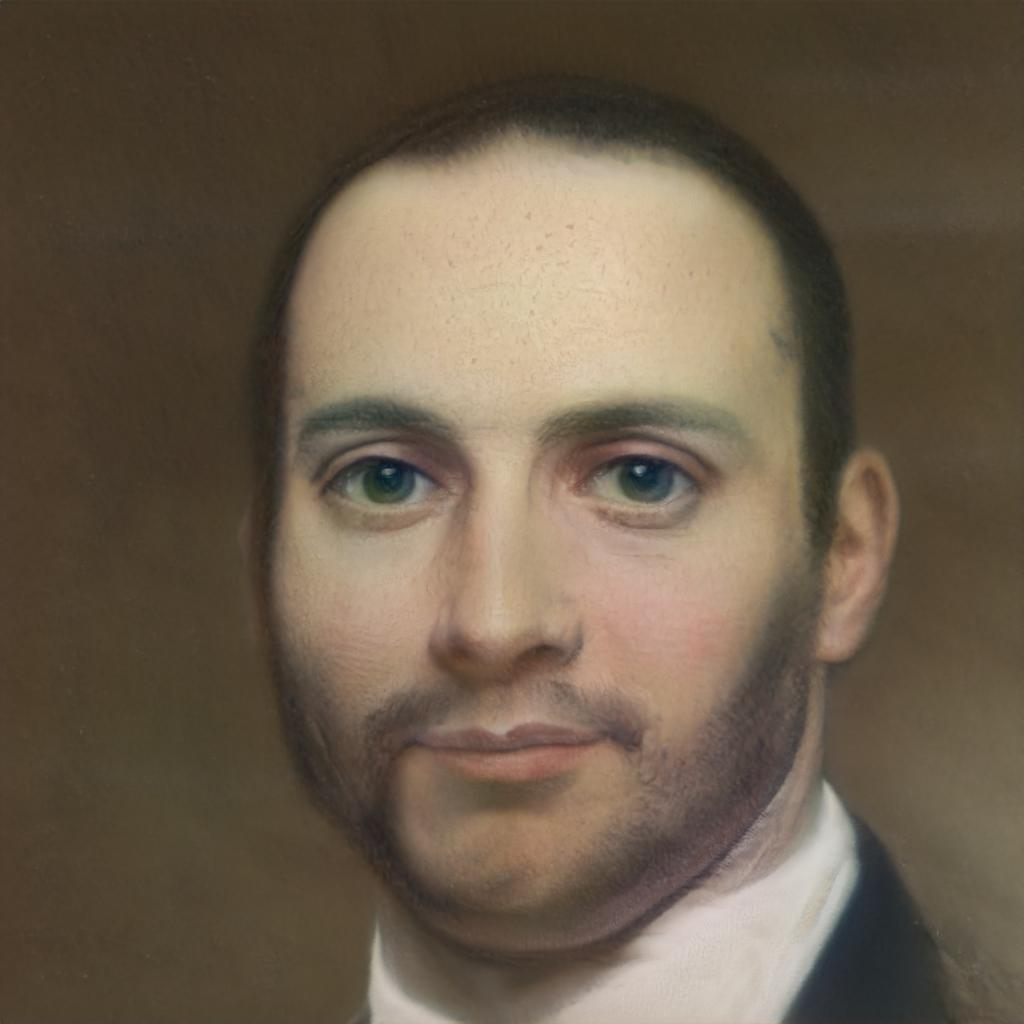

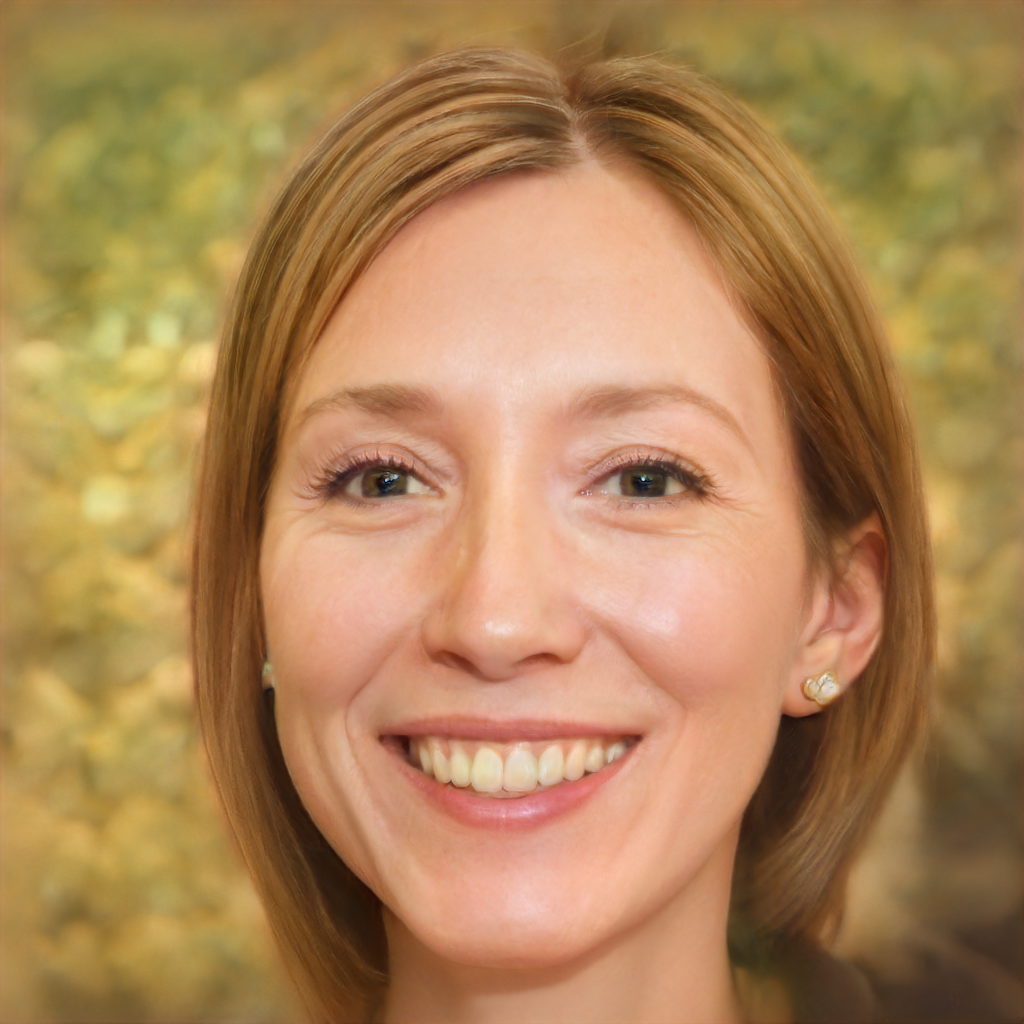

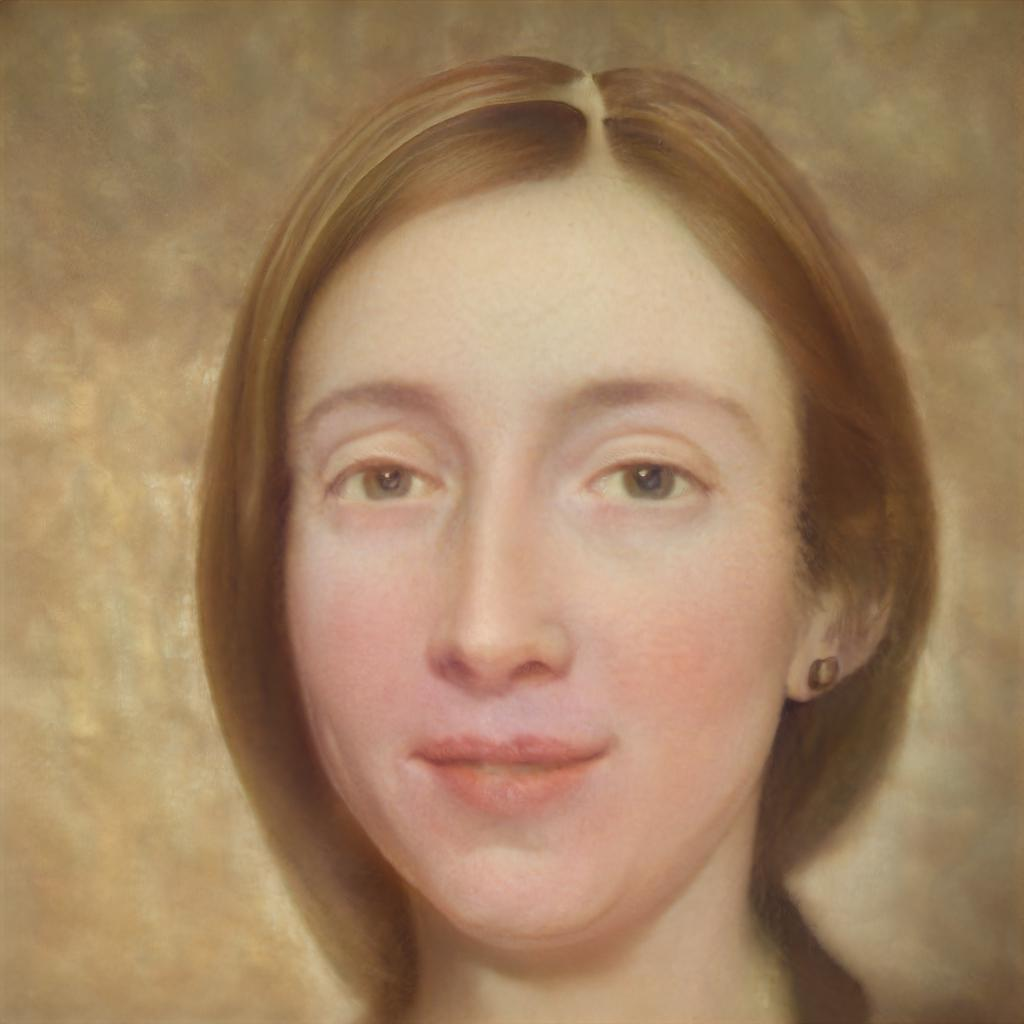

In [ ]:
from IPython.display import Image 
embedded = Image(filename="generated/example_sg1_01.png", width=256)
display(embedded)
tooned = Image(filename="generated/example_sg1_01-rennify.jpg", width=256)
display(tooned)
#===================================================================================
from IPython.display import Image 
embedded = Image(filename="generated/example_sg4_01.png", width=256)
display(embedded)
tooned = Image(filename="generated/example_sg4_01-rennify.jpg", width=256)
display(tooned)
#===================================================================================
from IPython.display import Image 
embedded = Image(filename="generated/example_sg7_01.png", width=256)
display(embedded)
tooned = Image(filename="generated/example_sg7_01-rennify.jpg", width=256)
display(tooned)
#===================================================================================
from IPython.display import Image 
embedded = Image(filename="generated/example_sg11_01.png", width=256)
display(embedded)
tooned = Image(filename="generated/example_sg11_01-rennify.jpg", width=256)
display(tooned)
#===================================================================================